In [9]:
#!pip install deap

import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random

In [10]:
t_total = 60  # minutos
massa_agua = 25.5
massa_malte = 8.5
massa_mosto = massa_agua + massa_malte
volume_malte = 13.6
volume_mosto = massa_agua + volume_malte
c = 4.1855  # kJ/kg°C
potencia = 6  # kW

T_min, T_max = 293.15, 403.15  # K (20°C a 130°C)
T0 = 293.15  # Temperatura inicial (K)

In [ ]:
def isomerizacao(T):
    return 7.9e11 * np.exp(-11858 / T)

def calcular_iso_total(T, time_step):
    T_iso = T[(T >= 363.15) & (T <= 403.15)]
    if len(T_iso) == 0:
        return 0
    taxas = isomerizacao(T_iso)
    return np.sum(taxas * time_step)

def calcular_energia_fornecida():
    return potencia * t_total * 60  # kJ

def energia_usada(delta_T):
    return c * massa_mosto * np.sum(delta_T)

def calcular_massa_evaporada(delta_T):
    energia_restante = calcular_energia_fornecida() - energia_usada(delta_T)
    h = 2257  # kJ/kg (entalpia de vaporização da água a 100°C)
    return energia_restante / h

def calcular_energia_termica_total(T):
    delta_T = np.diff(T, prepend=T0)
    return energia_usada(delta_T), delta_T

def calcular_densidade(massa_evaporada):
    massa_restante = massa_mosto - massa_evaporada
    volume_restante = volume_mosto - massa_evaporada
    return massa_restante / volume_restante

def calcular_penalizacao_densidade(densidade, faixa=(1000, 1025)):
    min_d, max_d = faixa
    if min_d <= densidade <= max_d:
        return 0
    desvio = min(abs(densidade - min_d), abs(densidade - max_d))
    return desvio / ((min_d + max_d) / 2)


In [ ]:
def func_objetivo_deap(individual):
    T = np.clip(np.array(individual), T_min, T_max)
    time_step = 60 / len(T)
    
    energia_total, delta_T = calcular_energia_termica_total(T)
    massa_evaporada = calcular_massa_evaporada(delta_T)
    iso_total = calcular_iso_total(T, time_step)
    densidade = calcular_densidade(massa_evaporada)

    energia_norm = energia_total / 10000
    iso_norm = iso_total / 1.0
    evap_norm = massa_evaporada / massa_mosto
    penalizacao_densidade = calcular_penalizacao_densidade(densidade)

    # Pesos, de acordo com o objetivo (Minimizar energia e evaporação, maximizar isomerização e regular a densidade), seção 3.3.3.(CONTROLE ÓTIMO MULTIOBJETIVO UTILIZANDO ALGORITMO GENÉTICO)
    w1, w2, w3, w4 = -1, -1, 1, 1

    score = (
        w1 * energia_norm +
        w3 * evap_norm +
        w4 * penalizacao_densidade -
        w2 * iso_norm
    )
    return (score,)


In [13]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, T_min, T_max)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=t_total)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", func_objetivo_deap)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [14]:
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

population, logbook = algorithms.eaSimple(
    population, toolbox,
    cxpb=0.5, mutpb=0.2, ngen=40,
    stats=stats, halloffame=hof,
    verbose=True
)

gen	nevals	avg    	std     	min     	max    
0  	50    	1.29043	0.565555	0.355152	2.47733
1  	32    	0.869156	0.306168	0.295602	1.67999
2  	24    	0.644318	0.239257	0.286729	1.19833
3  	27    	0.443979	0.215786	0.0427774	1.22477
4  	35    	0.312282	0.177925	-0.0789223	1.0162 
5  	33    	0.166891	0.130661	-0.0789223	0.479977
6  	33    	0.105211	0.134773	-0.0789223	0.637634
7  	29    	0.0361746	0.112955	-0.199016 	0.440322
8  	28    	-0.0263032	0.107483	-0.204877 	0.361695
9  	31    	-0.102086 	0.0781852	-0.213712 	0.134868
10 	32    	-0.125116 	0.0953557	-0.244682 	0.126748
11 	29    	-0.170154 	0.0545774	-0.25518  	-0.0622466
12 	27    	-0.201907 	0.0338932	-0.25518  	-0.101851 
13 	33    	-0.210971 	0.0500445	-0.290788 	-0.00714742
14 	41    	-0.224902 	0.0519939	-0.298714 	-0.00468984
15 	31    	-0.247204 	0.03963  	-0.298714 	-0.111764  
16 	33    	-0.265621 	0.0299125	-0.302406 	-0.144847  
17 	27    	-0.278591 	0.0256909	-0.302406 	-0.140975  
18 	33    	-0.28538  	0.0170005	-0.31

In [15]:
melhor_ind = hof[0]
melhor_T = np.clip(melhor_ind, T_min, T_max)
energia_total, delta_T = calcular_energia_termica_total(melhor_T)
massa_evaporada = calcular_massa_evaporada(delta_T)
iso_total = calcular_iso_total(np.array(melhor_T), 60/len(melhor_T))
densidade = calcular_densidade(massa_evaporada)

print("Temperaturas ótimas:", melhor_T)
print("Energia total:", energia_total)
print("Massa evaporada:", massa_evaporada)
print("Isomerização total:", iso_total)
print("Densidade final:", densidade)

Temperaturas ótimas: [348.81055256 348.31868733 322.32571267 323.81520916 293.15
 360.57412197 365.11172831 321.57068128 355.80801637 304.99695163
 361.62951657 342.51148707 358.10843184 312.50318034 310.78893454
 303.52627532 328.36601307 326.83044244 351.58877378 354.86040166
 336.92416633 327.49057884 333.86547141 345.28729663 343.92769529
 293.15       359.89909652 354.00899243 356.18091323 343.70110886
 304.87849502 327.54771774 322.58206833 333.68365877 293.15
 359.68291433 359.42873918 293.15       293.15       334.875731
 326.89920633 361.53865103 360.81173744 311.30963736 346.69366433
 337.85901457 339.34695362 293.15       316.95463168 323.99309822
 333.89679861 333.86832409 301.97841288 293.31862511 356.10999003
 339.63609588 341.66728566 295.42287661 300.40426005 403.15      ]
Energia total: 15653.770000000002
Massa evaporada: 2.6345724412937517
Isomerização total: 0.13911642127160986
Densidade final: 0.8601415000060143


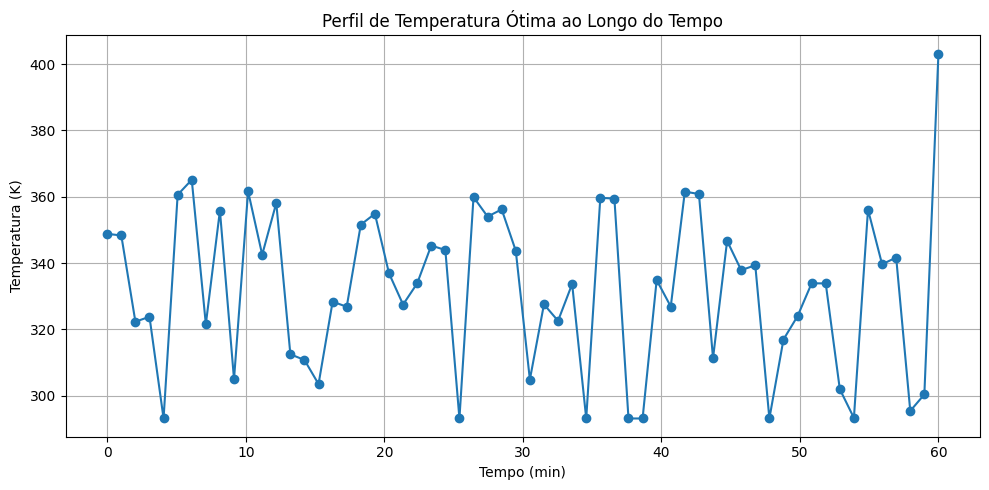

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 60, t_total), melhor_T, marker='o', linestyle='-')
plt.title("Perfil de Temperatura Ótima ao Longo do Tempo")
plt.xlabel("Tempo (min)")
plt.ylabel("Temperatura (K)")
plt.grid(True)
plt.tight_layout()
plt.show()